In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../../")

from helpers.split import make_train_test_split, tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

DATASET_FOLDER = "../../../datasets/"

In [2]:
# read a data set
df = pd.read_pickle(DATASET_FOLDER + "dataset_00_all.pickle")

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
pd.Series(y).value_counts()

7    5343
1    5276
9    4000
4    2126
5    1552
8     985
6     831
0     468
2     409
3     361
dtype: int64

In [5]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (21351, 2654) y.shape= (21351,)


In [6]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=True, stratify=y, 
)

In [7]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (17080, 2654)	y_train.shape = (17080,)
X_test.shape =  (4271, 2654)	y_test.shape =  (4271,)


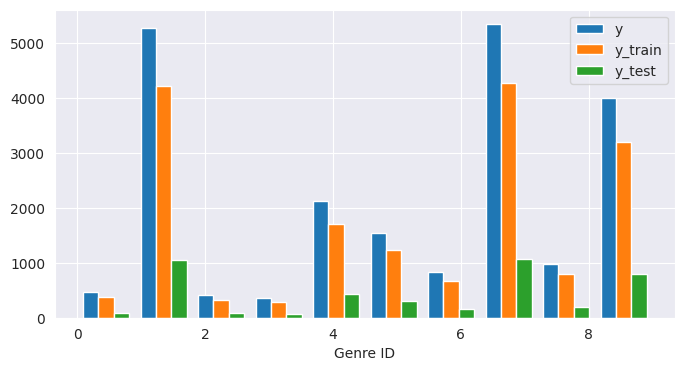

In [8]:
plt.figure(figsize=(8,4))
plt.hist([y, y_train, y_test],
         label=['y', 'y_train', 'y_test'])
plt.xlabel("Genre ID")
plt.legend()
plt.show()

In [9]:
scaler=StandardScaler()
#pca=KernelPCA(random_state=1962, n_components=200, n_jobs=-1)
#pca=PCA(random_state=1962, n_components=.85)
#pipe = Pipeline([('scaler', scaler),
#                 ('pca', pca)
#                ])

#No pip -- just scale the features
pipe=scaler

In [10]:
# run the scaling/PCA extraction pipe
X_train_pca = pipe.fit_transform(X_train)
X_test_pca = pipe.transform(X_test)

In [11]:
# review the shapes
print(f"{X_train_pca.shape= } {X_test_pca.shape= }")

X_train_pca.shape= (17080, 2654) X_test_pca.shape= (4271, 2654)


In [12]:
# Use SMOTE or SMOTE variant to resample the training data

#smt = SMOTE (random_state=1962, n_jobs=-1)

#enn = EditedNearestNeighbours(kind_sel='mode', n_neighbors=3, n_jobs=-1)
#smt = SMOTEENN (random_state=1962, enn=enn)

#smt = SMOTETomek(random_state=1962, n_jobs=-1)

#X_train_resampled, y_train_resampled = smt.fit_resample(X_train_pca, y_train)

# Pass through, no resampling, this is our baseline
X_train_resampled, y_train_resampled = X_train_pca, y_train

In [13]:
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  374]
 [   1 4221]
 [   2  327]
 [   3  289]
 [   4 1701]
 [   5 1241]
 [   6  665]
 [   7 4274]
 [   8  788]
 [   9 3200]]


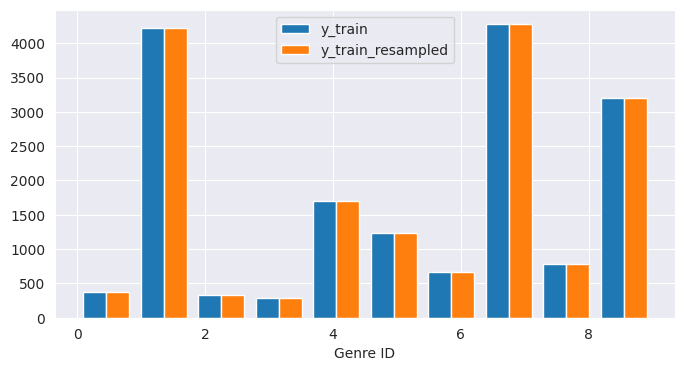

In [14]:
plt.figure(figsize=(8,4))
plt.hist([y_train, y_train_resampled],
         label=['y_train', 'y_train_resampled'])
plt.xlabel("Genre ID")
plt.legend()
plt.show()

In [15]:
model = XGBClassifier(
    use_label_encoder=False,
    tree_method='gpu_hist', 
    eta=.05,
    max_depth=6,
    reg_alpha=10,
    sampling_method='gradient_based',
    objective="multi:softprob", 
    eval_metric="mlogloss",
)

In [16]:
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric='mlogloss', gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, ...)

In [17]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.69


In [18]:
#kfold = KFold(n_splits=10, shuffle=True)
#kf_cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold)
#print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [19]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.7024116132053383

In [20]:
train_accuracy = model.score(X_train_resampled, y_train_resampled)
test_accuracy = model.score(X_test_pca, y_test)

In [21]:
print(f"Training accuracy: {train_accuracy:.4f}\n")
make_classification_report(
    y_train_resampled,
    model=model,
    x=X_train_resampled,
    digits=4,
    label_encoder=le,
    print_report=True,
    save_result=True,
    result_filename="rich_xgboost_results.json",
    model_name="XGBClassifier_baseline",
    dataset_name="dataset_00_all",
    phase="train",
    repeat=True,
    )
print(f"\nTesting accuracy: {test_accuracy:.4f}\n")
make_classification_report(
    y_test,
    y_pred=y_pred,
    digits=4,
    label_encoder=le,
    print_report=True,
    save_result=True,
    result_filename="rich_xgboost_results.json",
    model_name="XGBClassifier_baseline",
    dataset_name="dataset_00_all",
    phase="test",
    repeat=True,
    )
pass

Training accuracy: 0.8292

/tf/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_xgboost_results.json
File do not exist, creating file now
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     1.0000  0.1765    0.3000      374  0.4163
  genre_classical     0.9058  0.9360    0.9207     4221  0.8943
    genre_country     1.0000  0.4281    0.5996      327  0.6507
      genre_disco     0.9454  0.5986    0.7331      289  0.7492
     genre_hiphop     0.8502  0.9006    0.8747     1701  0.8608
       genre_jazz     0.8751  0.7228    0.7917     1241  0.7811
      genre_metal     0.9632  0.7083    0.8163      665  0.8203
        genre_pop     0.7168  0.8718    0.7867     4274  0.7125
     genre_reggae     0.9258  0.7919    0.8536      788  0.8499
       genre_rock     0.8223  0.8072    0.8147     3200  0.7725
                                       

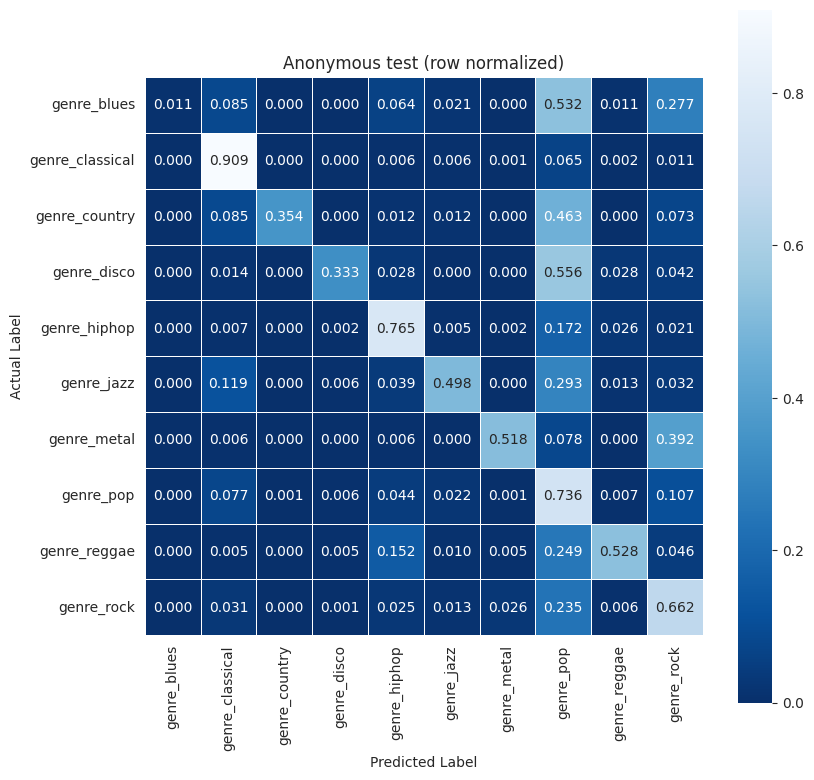

In [22]:
dataset_name="Anonymous"
make_confusion_matrix(
    y_test,
    y_pred=y_pred,
    label_encoder=le,
    title=f"{dataset_name} test (row normalized)",
)
pass

In [23]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric='mlogloss', gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, ...)

In [24]:
type(model)

xgboost.sklearn.XGBClassifier

In [25]:
model.objective

'multi:softprob'